# Segment trajectories using other odor thresholds

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np

import time_series
from db_api import models as d_models
from db_api.connect import session, commit

CONNECTED TO WIND TUNNEL PRODUCTION DATABASE
Are you sure you want to connect to the production database [y or n]?y


### Store a few additional threshold types

In [2]:
EXPT = 'fruitfly_0.3mps_checkerboard_floor'
THRESHOLDS = [1, 2, 5, 10, 20, 50, 100]
DETERMINATIONS = ['fly_0.3_mps_th_{}'.format(th_val) for th_val in THRESHOLDS]

In [7]:
for th_val, determination in zip(THRESHOLDS, DETERMINATIONS):
    threshold = d_models.Threshold(
        experiment_id=EXPT,
        determination=determination,
        value=th_val)
# uncomment next two lines to write to db again
    session.add(threshold)
    commit(session)

### Segment trajectories for each of these threshold types

In [3]:
expt = session.query(d_models.Experiment).get(EXPT)

for determination in DETERMINATIONS:
    
    print('Determination = {}'.format(determination))
    
    threshold = session.query(d_models.Threshold).filter_by(
        experiment=expt, determination=determination).first()

    odor_state = 'on'

    # make crossing group
    cg_id = '{}_{}_th_{}_{}'.format(expt.id, odor_state, threshold.value, determination)
    cg = d_models.CrossingGroup(
        id=cg_id, experiment=expt,
        odor_state=odor_state, threshold=threshold)
    session.add(cg)

    # get crossings for each trajectory
    for traj in session.query(d_models.Trajectory).\
        filter_by(experiment=expt, odor_state=odor_state, clean=True):

        segments, peaks = time_series.segment_by_threshold(
            traj.odors(session), threshold.value, traj.timepoint_ids_extended)

        # add crossings
        for s_ctr, (segment, peak) in enumerate(zip(segments, peaks)):
            crossing = d_models.Crossing(
                trajectory=traj, crossing_number=s_ctr + 1, crossing_group=cg)
            crossing.start_timepoint_id = segment[0]
            crossing.entry_timepoint_id = segment[1]
            crossing.peak_timepoint_id = segment[2]
            crossing.exit_timepoint_id = segment[3] - 1
            crossing.end_timepoint_id = segment[4] - 1
            crossing.max_odor = peak
            session.add(crossing)

#        commit(session)

Determination = fly_0.3_mps_th_1
Determination = fly_0.3_mps_th_2
Determination = fly_0.3_mps_th_5
Determination = fly_0.3_mps_th_10
Determination = fly_0.3_mps_th_20
Determination = fly_0.3_mps_th_50
Determination = fly_0.3_mps_th_100


### Add basic features to each crossing

In [13]:
CROSSING_GROUP_IDS = [
    'fruitfly_0.3mps_checkerboard_floor_on_th_1.0_fly_0.3_mps_th_1',
    'fruitfly_0.3mps_checkerboard_floor_on_th_2.0_fly_0.3_mps_th_2',
    'fruitfly_0.3mps_checkerboard_floor_on_th_5.0_fly_0.3_mps_th_5',
    'fruitfly_0.3mps_checkerboard_floor_on_th_10.0_fly_0.3_mps_th_10',
    'fruitfly_0.3mps_checkerboard_floor_on_th_20.0_fly_0.3_mps_th_20',
    'fruitfly_0.3mps_checkerboard_floor_on_th_50.0_fly_0.3_mps_th_50',
    'fruitfly_0.3mps_checkerboard_floor_on_th_100.0_fly_0.3_mps_th_100',
]

for cg_id in CROSSING_GROUP_IDS:
    cg = session.query(d_models.CrossingGroup).filter_by(id=cg_id).first()
    
    print(cg.id)
    
    for crossing in cg.crossings:

        position_x_entry = crossing.timepoint_field(session, 'position_x', 0, 0, 'entry', 'entry')[0]
        position_y_entry = crossing.timepoint_field(session, 'position_y', 0, 0, 'entry', 'entry')[0]
        position_z_entry = crossing.timepoint_field(session, 'position_z', 0, 0, 'entry', 'entry')[0]

        position_x_peak = crossing.timepoint_field(session, 'position_x', 0, 0, 'peak', 'peak')[0]
        position_y_peak = crossing.timepoint_field(session, 'position_y', 0, 0, 'peak', 'peak')[0]
        position_z_peak = crossing.timepoint_field(session, 'position_z', 0, 0, 'peak', 'peak')[0]

        position_x_exit = crossing.timepoint_field(session, 'position_x', 0, 0, 'exit', 'exit')[0]
        position_y_exit = crossing.timepoint_field(session, 'position_y', 0, 0, 'exit', 'exit')[0]
        position_z_exit = crossing.timepoint_field(session, 'position_z', 0, 0, 'exit', 'exit')[0]

        heading_xy_entry = crossing.timepoint_field(session, 'heading_xy', 0, 0, 'entry', 'entry')[0]
        heading_xz_entry = crossing.timepoint_field(session, 'heading_xz', 0, 0, 'entry', 'entry')[0]
        heading_xyz_entry = crossing.timepoint_field(session, 'heading_xyz', 0, 0, 'entry', 'entry')[0]

        heading_xy_peak = crossing.timepoint_field(session, 'heading_xy', 0, 0, 'peak', 'peak')[0]
        heading_xz_peak = crossing.timepoint_field(session, 'heading_xz', 0, 0, 'peak', 'peak')[0]
        heading_xyz_peak = crossing.timepoint_field(session, 'heading_xyz', 0, 0, 'peak', 'peak')[0]

        heading_xy_exit = crossing.timepoint_field(session, 'heading_xy', 0, 0, 'exit', 'exit')[0]
        heading_xz_exit = crossing.timepoint_field(session, 'heading_xz', 0, 0, 'exit', 'exit')[0]
        heading_xyz_exit = crossing.timepoint_field(session, 'heading_xyz', 0, 0, 'exit', 'exit')[0]

        crossing.feature_set_basic = d_models.CrossingFeatureSetBasic(
            position_x_entry=position_x_entry,
            position_y_entry=position_y_entry,
            position_z_entry=position_z_entry,
            position_x_peak=position_x_peak,
            position_y_peak=position_y_peak,
            position_z_peak=position_z_peak,
            position_x_exit=position_x_exit,
            position_y_exit=position_y_exit,
            position_z_exit=position_z_exit,
            heading_xy_entry=heading_xy_entry,
            heading_xz_entry=heading_xz_entry,
            heading_xyz_entry=heading_xyz_entry,
            heading_xy_peak=heading_xy_peak,
            heading_xz_peak=heading_xz_peak,
            heading_xyz_peak=heading_xyz_peak,
            heading_xy_exit=heading_xy_exit,
            heading_xz_exit=heading_xz_exit,
            heading_xyz_exit=heading_xyz_exit)

        session.add(crossing)
        commit(session)

fruitfly_0.3mps_checkerboard_floor_on_th_1.0_fly_0.3_mps_th_1
fruitfly_0.3mps_checkerboard_floor_on_th_2.0_fly_0.3_mps_th_2
fruitfly_0.3mps_checkerboard_floor_on_th_5.0_fly_0.3_mps_th_5
fruitfly_0.3mps_checkerboard_floor_on_th_10.0_fly_0.3_mps_th_10
fruitfly_0.3mps_checkerboard_floor_on_th_20.0_fly_0.3_mps_th_20
fruitfly_0.3mps_checkerboard_floor_on_th_50.0_fly_0.3_mps_th_50
fruitfly_0.3mps_checkerboard_floor_on_th_100.0_fly_0.3_mps_th_100


### Display history dependence plots for each threshold

CROSSING GROUP "TH 1"
CROSSING SUBSET "early"
847 CROSSINGS; 724 UNIQUE TRAJECTORIES
CROSSING GROUP "TH 1"
CROSSING SUBSET "late"
880 CROSSINGS; 572 UNIQUE TRAJECTORIES
COEFS (X_0, T_FLIGHT) FOR CROSSING GROUP TH 1
MEANS: (-11.78553, 0.14390)
STDS: (11.28260, 0.42410)
CROSSING GROUP "TH 2"
CROSSING SUBSET "early"
823 CROSSINGS; 707 UNIQUE TRAJECTORIES
CROSSING GROUP "TH 2"
CROSSING SUBSET "late"
856 CROSSINGS; 555 UNIQUE TRAJECTORIES
COEFS (X_0, T_FLIGHT) FOR CROSSING GROUP TH 2
MEANS: (-12.46046, 0.01129)
STDS: (10.04060, 0.45986)
CROSSING GROUP "TH 5"
CROSSING SUBSET "early"
790 CROSSINGS; 678 UNIQUE TRAJECTORIES
CROSSING GROUP "TH 5"
CROSSING SUBSET "late"
819 CROSSINGS; 532 UNIQUE TRAJECTORIES
COEFS (X_0, T_FLIGHT) FOR CROSSING GROUP TH 5
MEANS: (-10.61813, -0.03075)
STDS: (9.28324, 0.38513)
CROSSING GROUP "TH 10"
CROSSING SUBSET "early"
783 CROSSINGS; 672 UNIQUE TRAJECTORIES
CROSSING GROUP "TH 10"
CROSSING SUBSET "late"
766 CROSSINGS; 498 UNIQUE TRAJECTORIES
COEFS (X_0, T_FLIGHT) 

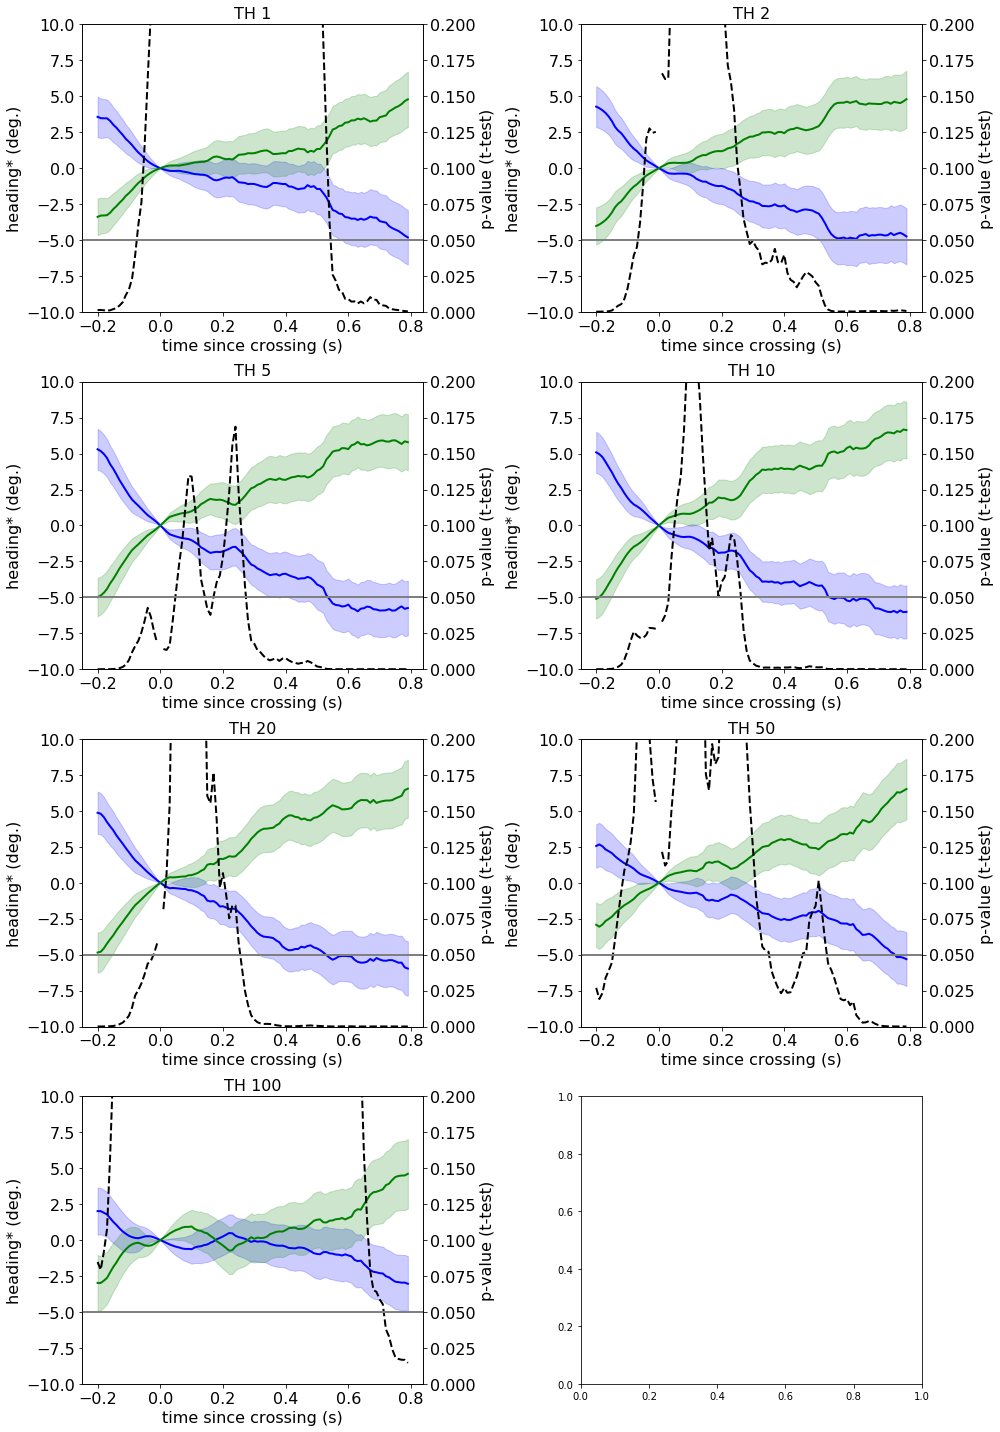

In [14]:
%matplotlib inline
import pdb
import numpy as np
from view.final_figures import early_vs_late_heading_timecourse_given_x0_and_t_flight

f_4 = early_vs_late_heading_timecourse_given_x0_and_t_flight(
    CROSSING_GROUP_IDS=[
        'fruitfly_0.3mps_checkerboard_floor_on_th_1.0_fly_0.3_mps_th_1',
        'fruitfly_0.3mps_checkerboard_floor_on_th_2.0_fly_0.3_mps_th_2',
        'fruitfly_0.3mps_checkerboard_floor_on_th_5.0_fly_0.3_mps_th_5',
        'fruitfly_0.3mps_checkerboard_floor_on_th_10.0_fly_0.3_mps_th_10',
        'fruitfly_0.3mps_checkerboard_floor_on_th_20.0_fly_0.3_mps_th_20',
        'fruitfly_0.3mps_checkerboard_floor_on_th_50.0_fly_0.3_mps_th_50',
        'fruitfly_0.3mps_checkerboard_floor_on_th_100.0_fly_0.3_mps_th_100',
    ],
    CROSSING_GROUP_LABELS={
        'fruitfly_0.3mps_checkerboard_floor_on_th_1.0_fly_0.3_mps_th_1': 'TH 1',
        'fruitfly_0.3mps_checkerboard_floor_on_th_2.0_fly_0.3_mps_th_2': 'TH 2',
        'fruitfly_0.3mps_checkerboard_floor_on_th_5.0_fly_0.3_mps_th_5': 'TH 5',
        'fruitfly_0.3mps_checkerboard_floor_on_th_10.0_fly_0.3_mps_th_10': 'TH 10',
        'fruitfly_0.3mps_checkerboard_floor_on_th_20.0_fly_0.3_mps_th_20': 'TH 20',
        'fruitfly_0.3mps_checkerboard_floor_on_th_50.0_fly_0.3_mps_th_50': 'TH 50',
        'fruitfly_0.3mps_checkerboard_floor_on_th_100.0_fly_0.3_mps_th_100': 'TH 100',
    },
    X_0_MIN=0.,
    X_0_MAX=0.7,
    H_0_MIN=60,
    H_0_MAX=120,
    CROSSING_NUMBER_MAX=5,
    MAX_CROSSINGS_EARLY=2,
    SUBTRACT_INITIAL_HEADING=True,
    T_BEFORE=0.2,
    T_AFTER=0.8,
    ADJUST_NS=True,
    AX_SIZE=(7, 5),
    AX_GRID=(4, 2),
    EARLY_LATE_COLORS={'early': 'b', 'late': 'g'},
    ALPHA=0.2,
    P_VAL_COLOR='k',
    P_VAL_Y_LIM=(0, 0.2),
    LEGEND_CROSSING_GROUP_ID=None,
    FONT_SIZE=16);

# Run infotaxis simulations with varying thresholds

### Run simulations

In [1]:
from scripts.infotaxis.generate_wind_tunnel_discretized_matched_trials_one_for_one import main

EXPT = 'fruitfly_0.3mps_checkerboard_floor'
ODOR_STATE = 'on'

INSECT_PARAMS = {
        'r': 1000,  # source emission rate
        'd': 0.09,  # diffusivity (m^2/s)
        'a': .002,  # searcher size (m)
        'tau': 10000  # particle lifetime (s)
        }

THRESHOLDS = [1, 2, 5, 10, 20, 50, 100]

for threshold in THRESHOLDS:

    SCRIPTNOTES = 'Run for {}, odor {}, d = {} m^2/s, r = {} Hz, threshold {}.'.format(
        EXPT, ODOR_STATE, INSECT_PARAMS['d'], INSECT_PARAMS['r'], threshold)
    
    sim_ids = {
        (EXPT, ODOR_STATE): 'revision_th_{}_{}_{}_d_{}_r_{}'.format(
            threshold, EXPT, ODOR_STATE, INSECT_PARAMS['d'], INSECT_PARAMS['r']),
    }
    
    sim_descs = {
        (EXPT, ODOR_STATE): 'for paper revision',
    }

    main(
        INSECT_PARAMS=INSECT_PARAMS, SCRIPTNOTES=SCRIPTNOTES,
        expts=[EXPT], odor_states=[ODOR_STATE],
        threshold=threshold, sim_ids=sim_ids, sim_descs=sim_descs)

CONNECTED TO INFOTAXIS PRODUCTION DATABASE
Are you sure you want to connect to the production database [y or n]?y
Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 1


logprob_odor.py:78: RuntimeWarning: divide by zero encountered in divide
  rate = (a*r/dr) * np.exp(exponent)
/Users/rkp/anaconda/envs/py2/lib/python2.7/site-packages/sqlalchemy/engine/default.py:470: Warning: Data truncated for column 'hxyz' at row 1
  cursor.execute(statement, parameters)


Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 2
Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 5
Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 10
Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 20
Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 50
Running simulation for expt "fruitfly_0.3mps_checkerboard_floor" with odor "on"...
Setting plume detectability threshold to 100


### Identify plume crossings and store in database

In [2]:
from scripts.infotaxis.identify_plume_crossings import main

EXPT = 'fruitfly_0.3mps_checkerboard_floor'
ODOR_STATE = 'on'

INSECT_PARAMS = {
        'r': 1000,  # source emission rate
        'd': 0.09,  # diffusivity (m^2/s)
        'a': .002,  # searcher size (m)
        'tau': 10000  # particle lifetime (s)
        }

THRESHOLDS = [1, 2, 5, 10, 20, 50, 100]

sim_ids = [
    'revision_th_{}_{}_{}_d_{}_r_{}'.format(threshold, EXPT, ODOR_STATE, INSECT_PARAMS['d'], INSECT_PARAMS['r'])
    for threshold in THRESHOLDS
]

for sim_id, threshold in zip(sim_ids, THRESHOLDS):
    main(sim_ids=[sim_id], thresholds={'fly': threshold})

CONNECTED TO INFOTAXIS PRODUCTION DATABASE
Are you sure you want to connect to the production database [y or n]?y
Identifying crossings from simulation: "revision_th_1_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000"
Storing in crossing group:
revision_th_1_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000_th_1_hsmoothing_3
Identifying crossings from simulation: "revision_th_2_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000"
Storing in crossing group:
revision_th_2_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000_th_2_hsmoothing_3
Identifying crossings from simulation: "revision_th_5_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000"
Storing in crossing group:
revision_th_5_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000_th_5_hsmoothing_3
Identifying crossings from simulation: "revision_th_10_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000"
Storing in crossing group:
revision_th_10_fruitfly_0.3mps_checkerboard_floor_on_d_0.09_r_1000_th_10_hsmoothing_3
Identifying

### Plot history-dependence results

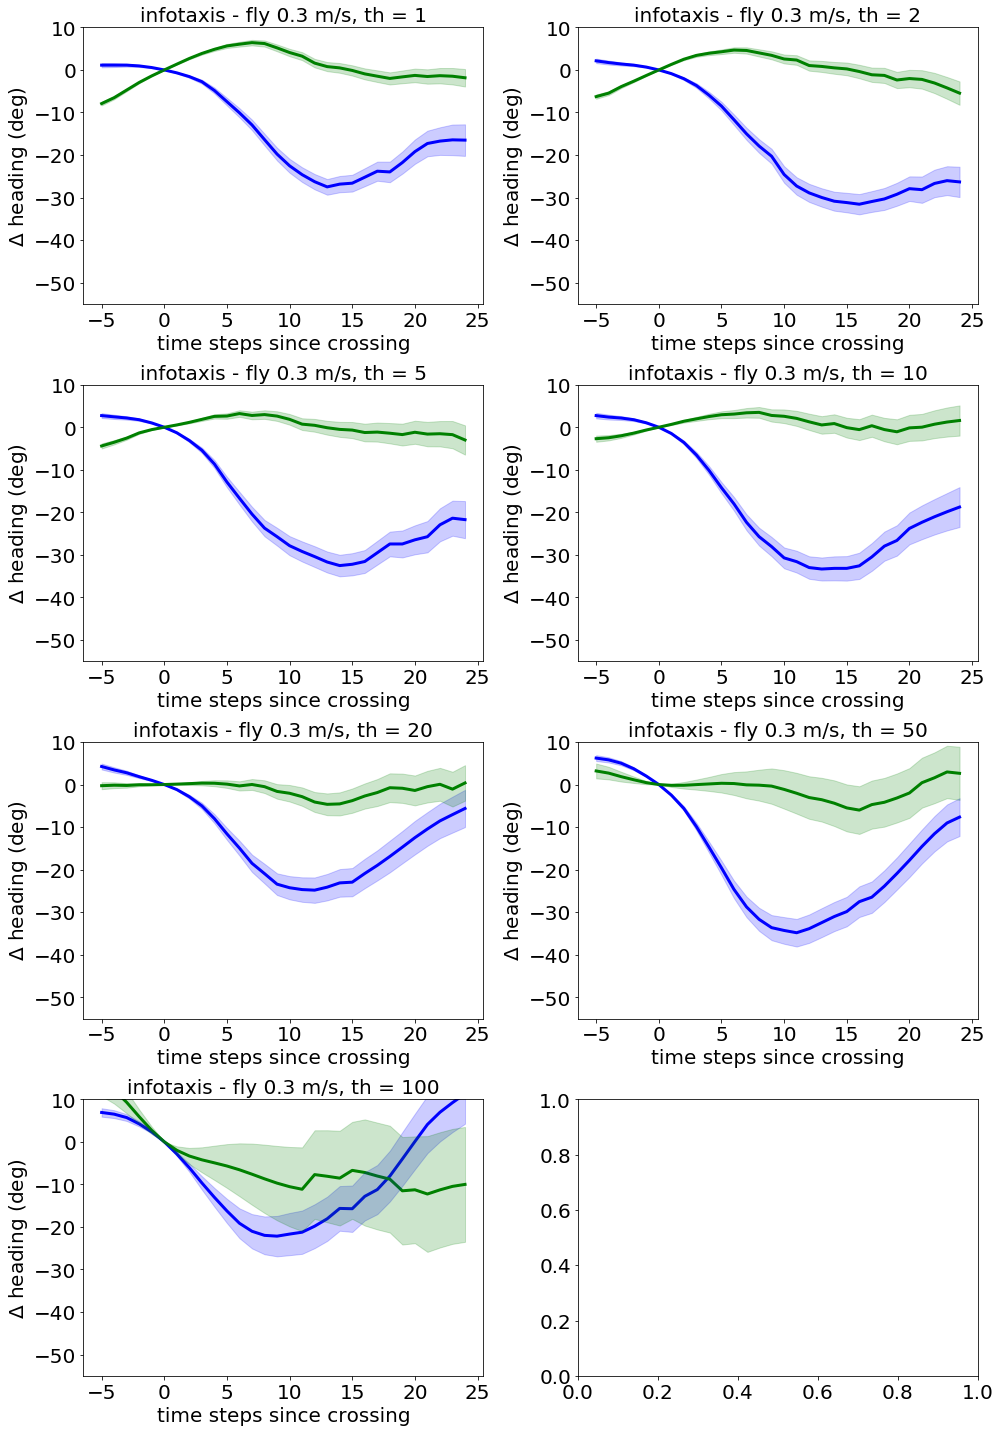

In [5]:
%matplotlib inline
import pdb
import numpy as np
from view.final_figures import infotaxis_history_dependence

EXPT = 'fruitfly_0.3mps_checkerboard_floor'
ODOR_STATE = 'on'

INSECT_PARAMS = {
        'r': 1000,  # source emission rate
        'd': 0.09,  # diffusivity (m^2/s)
        'a': .002,  # searcher size (m)
        'tau': 10000  # particle lifetime (s)
        }

THRESHOLDS = [1, 2, 5, 10, 20, 50, 100]

sim_ids = [
    'revision_th_{}_{}_{}_d_{}_r_{}'.format(threshold, EXPT, ODOR_STATE, INSECT_PARAMS['d'], INSECT_PARAMS['r'])
    for threshold in THRESHOLDS
]

cg_ids = [
    '{}_th_{}_hsmoothing_{}'.format(sim_id, threshold, 3)
    for sim_id, threshold in zip(sim_ids, THRESHOLDS)
]

cg_labels = {
    cg_id: 'fly 0.3 m/s, th = {}'.format(threshold)
    for cg_id, threshold in zip(cg_ids, THRESHOLDS)
}

fig = infotaxis_history_dependence(
    WIND_TUNNEL_CG_IDS=None,
    INFOTAXIS_WIND_SPEED_CG_IDS=None,
    MAX_CROSSINGS=np.inf,
    INFOTAXIS_HISTORY_DEPENDENCE_CG_IDS=cg_ids,
    MAX_CROSSINGS_EARLY=2,
    X_0_MIN=0.,
    X_0_MAX=0.7,
    H_0_MIN=60,
    H_0_MAX=120,
    X_0_MIN_SIM=0,
    X_0_MAX_SIM=65,
    X_0_MIN_SIM_HISTORY=15,
    X_0_MAX_SIM_HISTORY=50,
    T_BEFORE_EXPT=0.2,
    T_AFTER_EXPT=0.8,
    TS_BEFORE_SIM=5,
    TS_AFTER_SIM=25,
    HEADING_SMOOTHING_SIM=3,
    Y_LIM=(-55, 10),
    AX_GRID=(4, 2),
    AX_SIZE=(5, 7),
    FONT_SIZE=20,
    EXPT_LABELS=None,
    EXPT_COLORS=None,
    SIM_LABELS=cg_labels,
    SAVE_FILE_PREFIX='infotaxis_temp_history_dependence_vary_th')

# Run surge-cast simulations for different thresholds

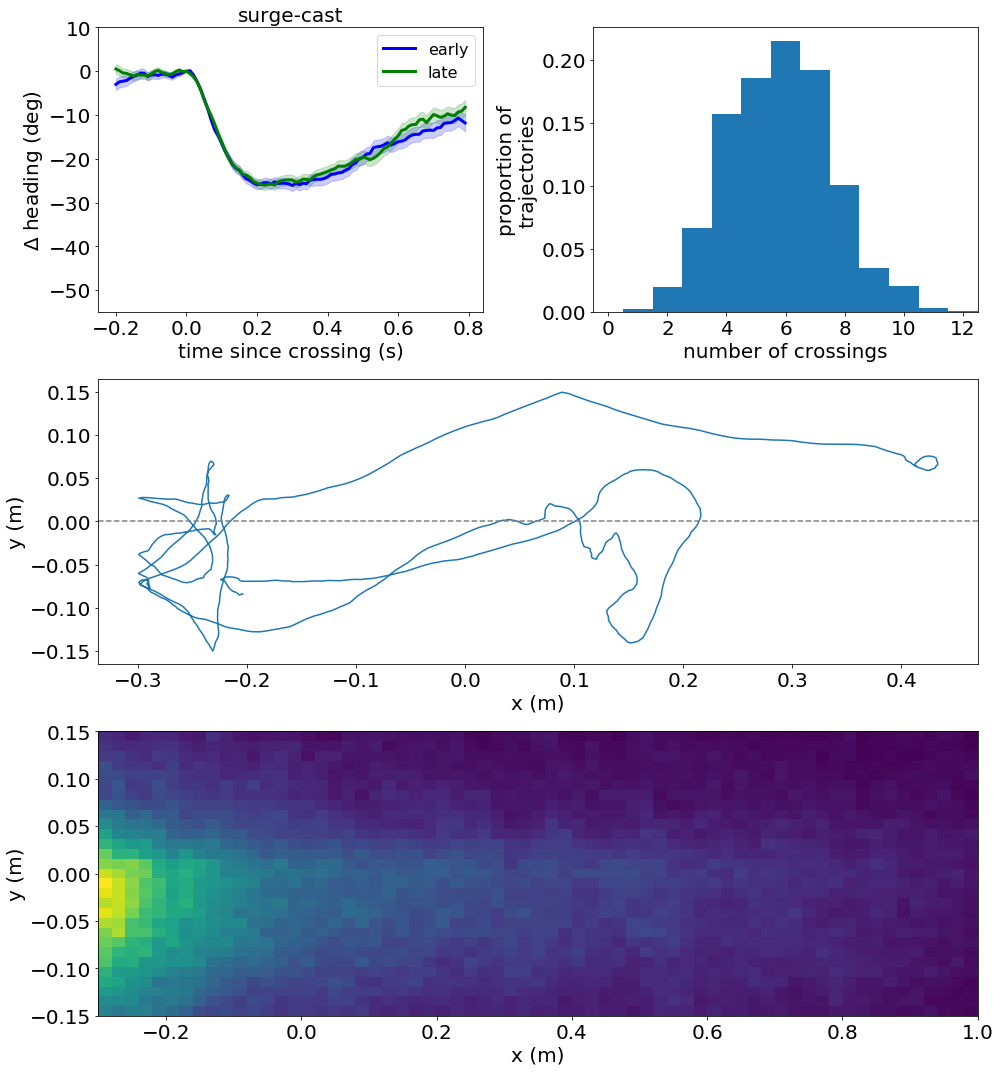

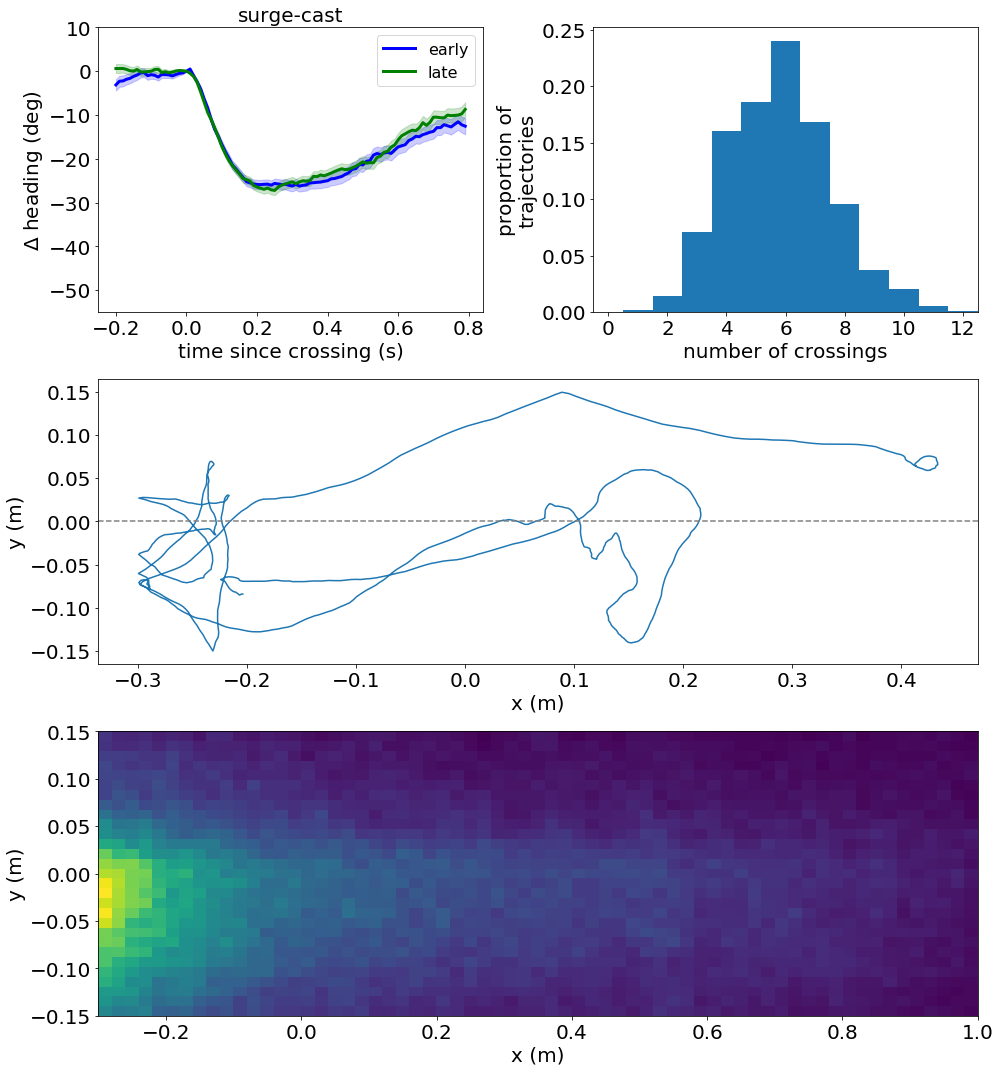

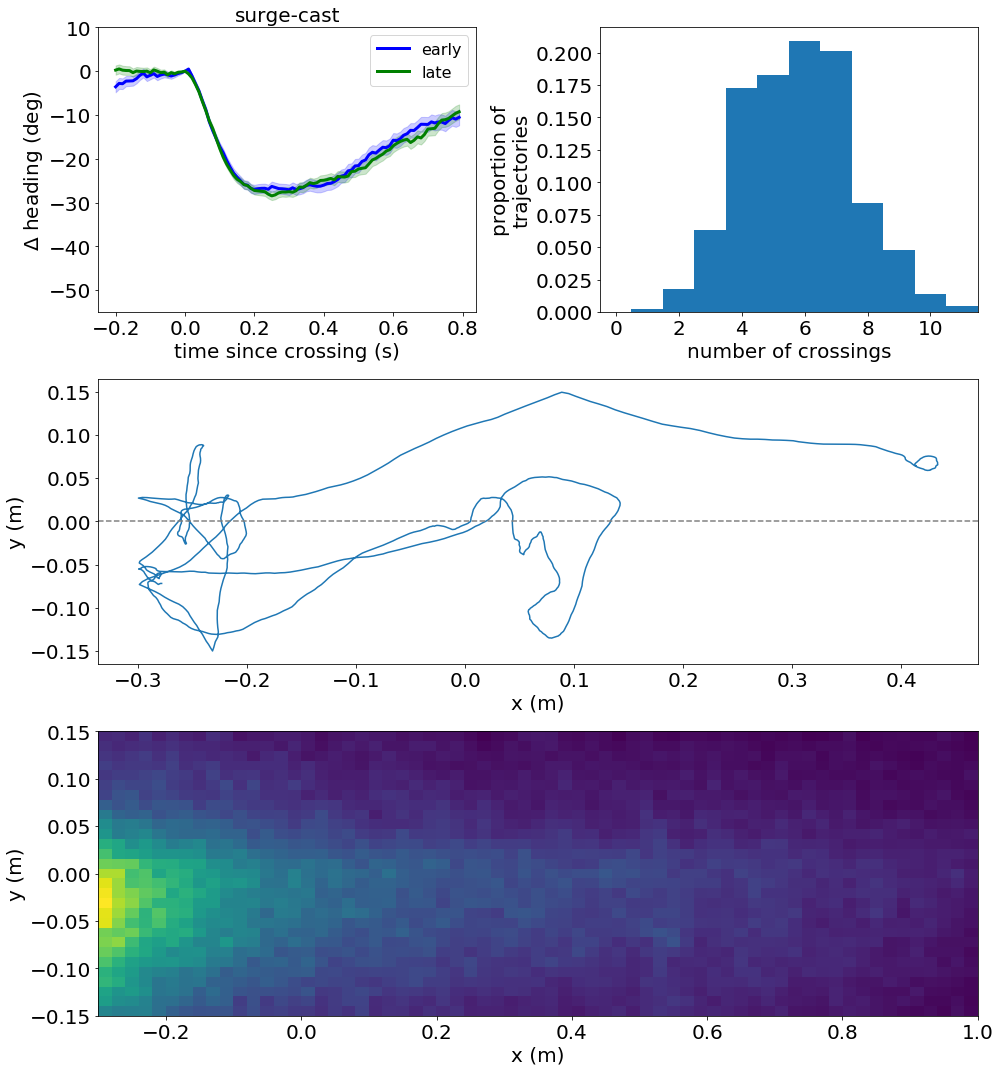

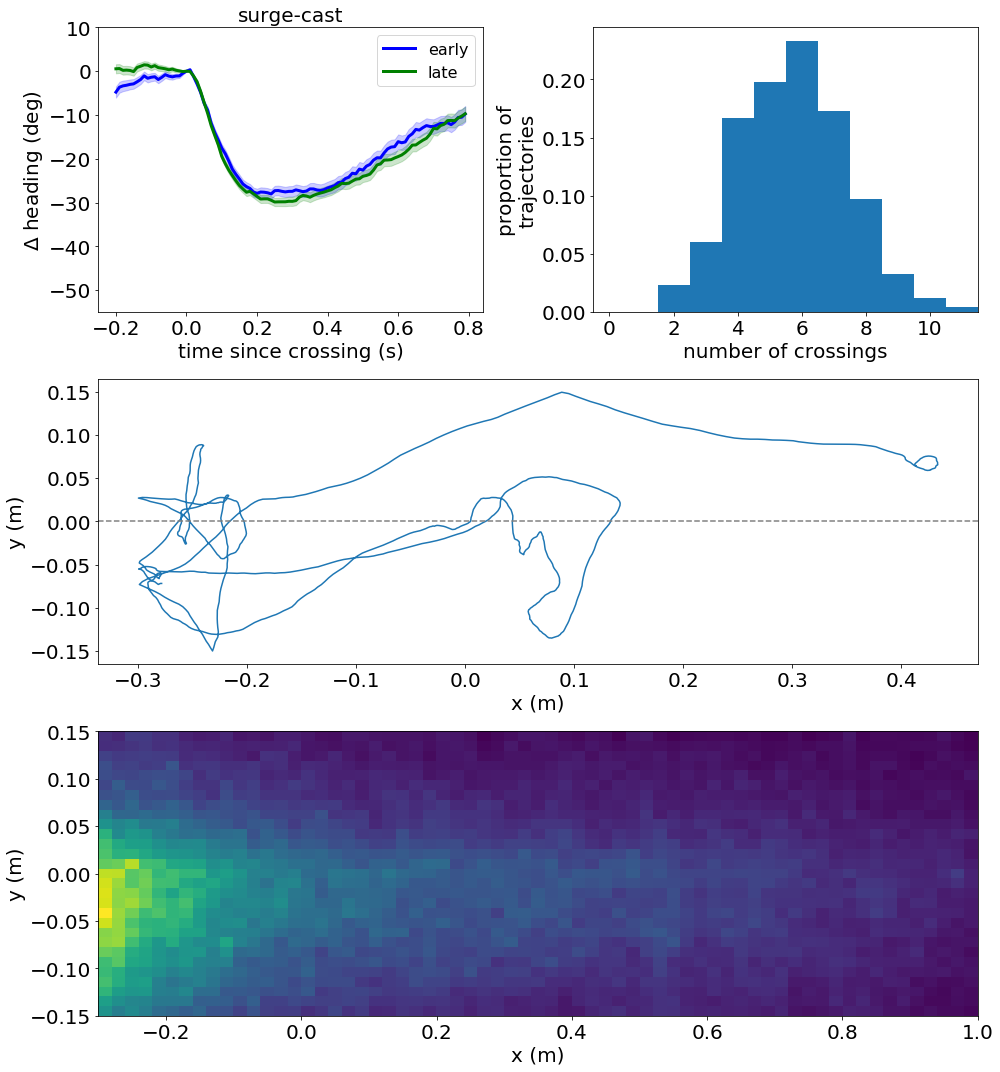

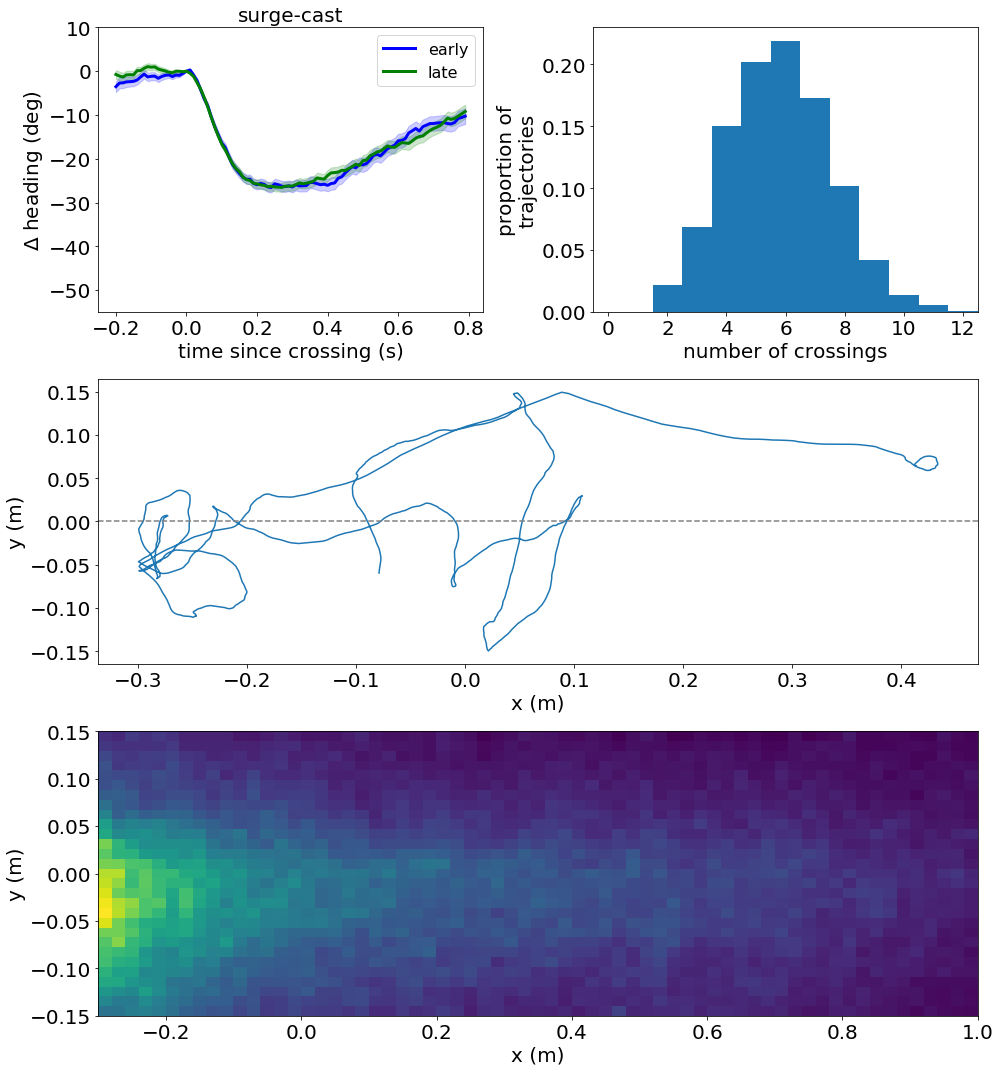

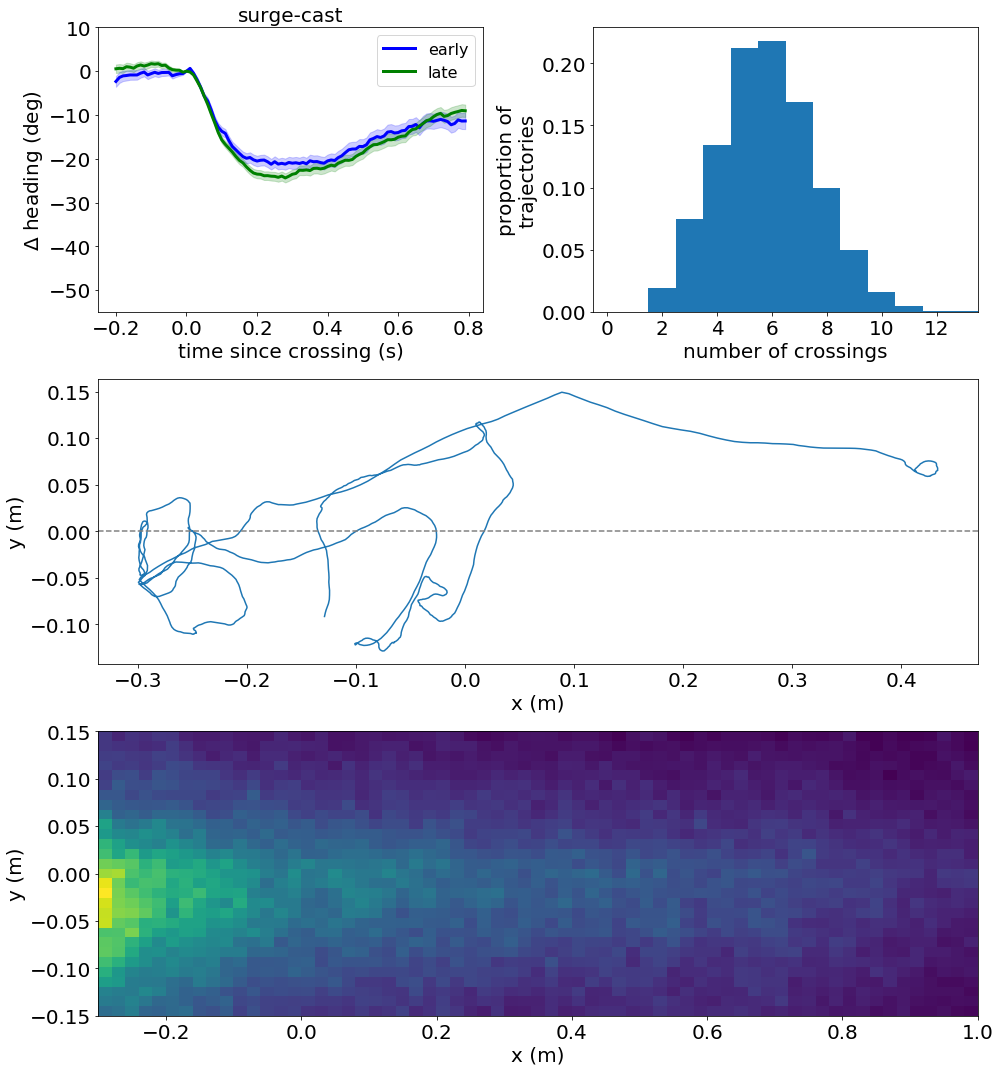

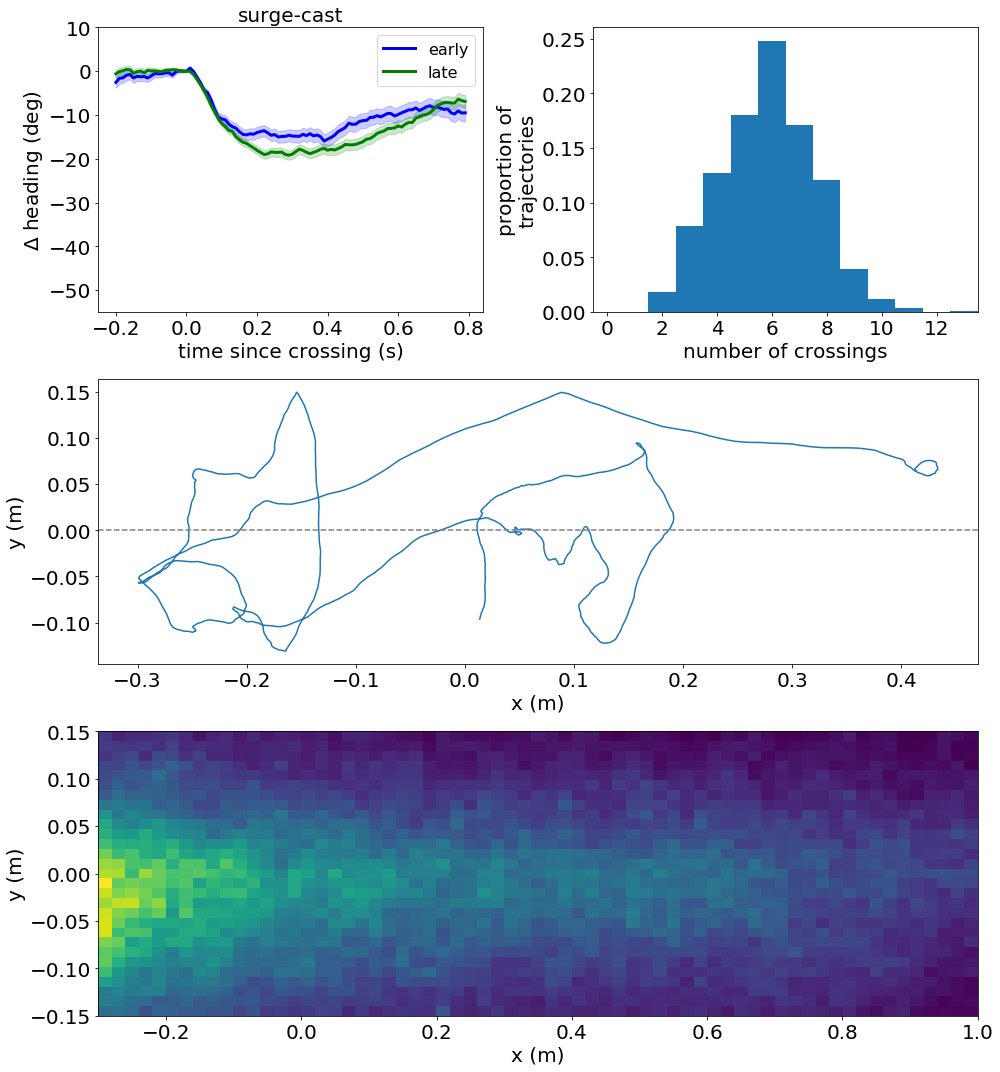

In [6]:
%matplotlib inline
import numpy as np
from view.final_figures import early_late_heading_timecourse_surge_cast

THRESHOLDS = [1, 2, 5, 10, 20, 50, 100]

for threshold in THRESHOLDS:
    
    save_file = 'surge_cast_temp_history_dependence_th_{}'.format(threshold)
    
    fig = early_late_heading_timecourse_surge_cast(
        SEED=0, N_TRAJS=1000,

        DURATION=10,
        DT=0.01,
        TAU=0.42, NOISE=1.9, BIAS=0.25,
        AGENT_THRESHOLD=threshold,
        SURGE_AMP=.8,
        TAU_SURGE=.07,
        BOUNDS=[(-0.3, 1), (-0.15, 0.15), (-0.15, 0.15)],

        PL_CONC=195,
        PL_MEAN=np.array([0., 0]),
        PL_STD=np.array([0.0139, 0.024]),

        ANALYSIS_THRESHOLD=10, H_0_MIN=60, H_0_MAX=120, X_0_MIN=0., X_0_MAX=0.7,
        MAX_CROSSINGS_EARLY=2,
        SUBTRACT_PEAK_HEADING=True, T_BEFORE=0.2, T_AFTER=0.8,
        Y_LIM=(-55, 10),
        SAVE_FILE=save_file)

# Run hybrid model analysis for different thresholds

Calculating empirical early-late difference...
Empirical late-early diff = 6.10159998268 deg.
Calculating empirical early-late difference...
Empirical late-early diff = 7.54558926844 deg.
Calculating empirical early-late difference...
Empirical late-early diff = 8.11382636609 deg.
Calculating empirical early-late difference...
Empirical late-early diff = 8.72193088107 deg.
Calculating empirical early-late difference...
Empirical late-early diff = 8.55324576305 deg.
Calculating empirical early-late difference...
Empirical late-early diff = 5.77779841368 deg.
Calculating empirical early-late difference...
Empirical late-early diff = 4.02111848809 deg.


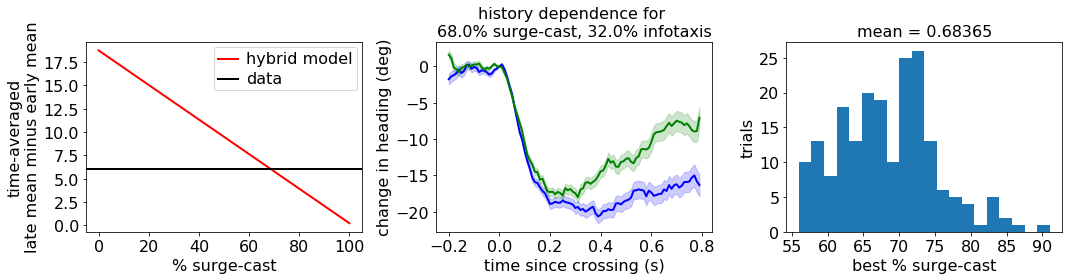

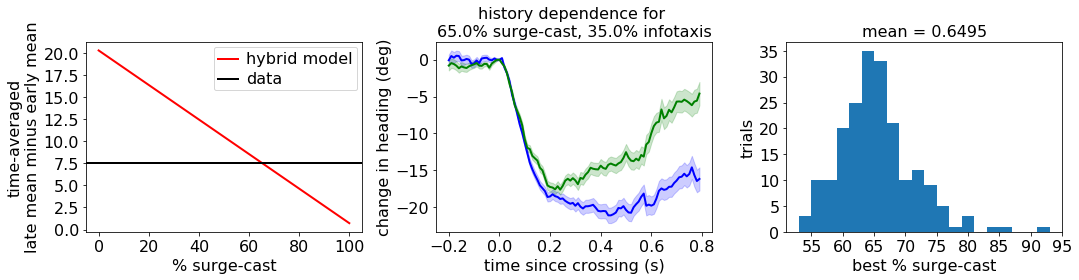

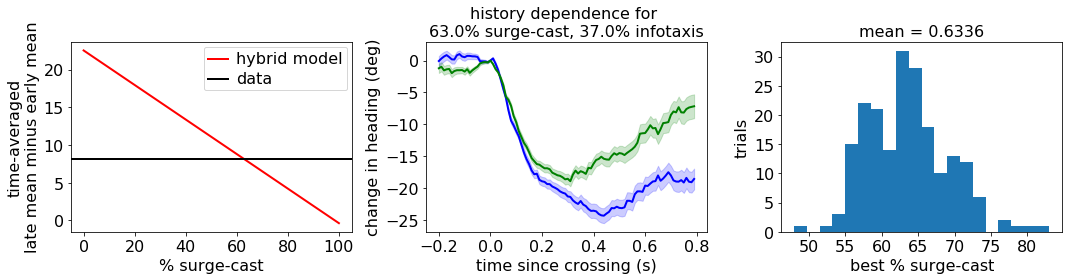

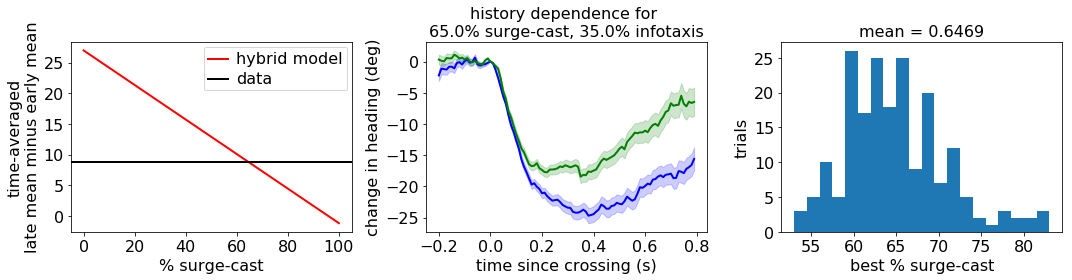

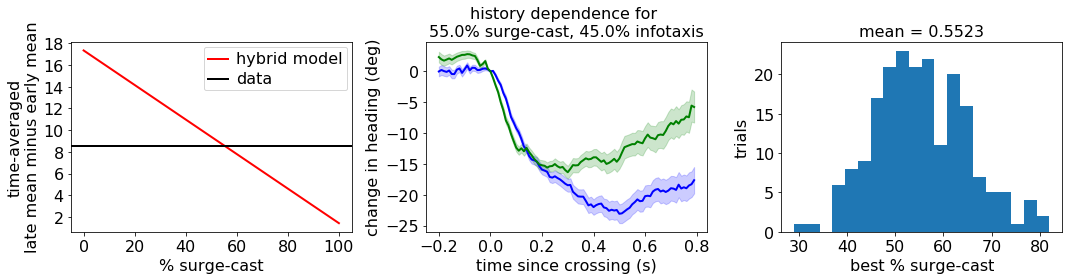

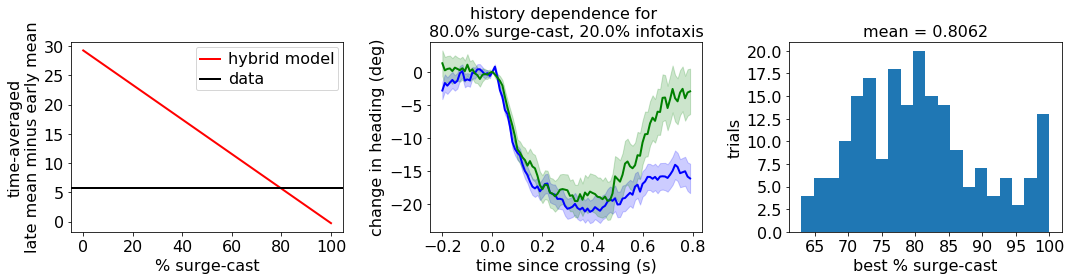

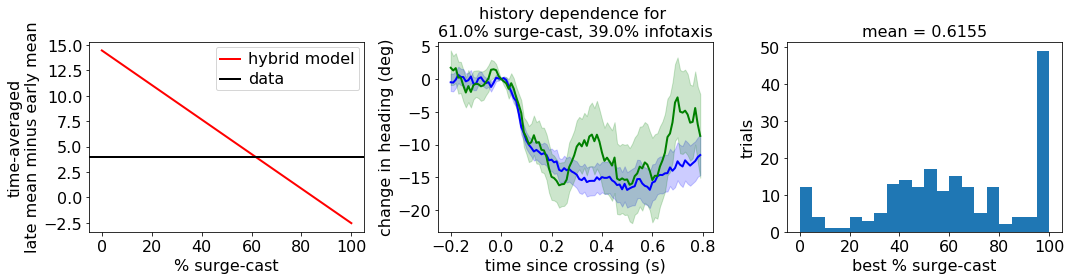

In [10]:
%matplotlib inline
from view.final_figures import hybrid_model_history_dependence

EXPT = 'fruitfly_0.3mps_checkerboard_floor'
ODOR_STATE = 'on'

INSECT_PARAMS = {
        'r': 1000,  # sourTHRESHOLDSission rate
        'd': 0.09,  # diffusivity (m^2/s)
        'a': .002,  # searcher size (m)
        'tau': 10000  # particle lifetime (s)
        }

THRESHOLDS = [1, 2, 5, 10, 20, 50, 100]

sim_ids = [
    'revision_th_{}_{}_{}_d_{}_r_{}'.format(threshold, EXPT, ODOR_STATE, INSECT_PARAMS['d'], INSECT_PARAMS['r'])
    for threshold in THRESHOLDS
]

INFO_CG_IDS = [
    '{}_th_{}_hsmoothing_{}'.format(sim_id, threshold, 3)
    for sim_id, threshold in zip(sim_ids, THRESHOLDS)
]

SURGE_CAST_FILES = [
    'surge_cast_temp_history_dependence_th_{}_full.npy'.format(threshold)
    for threshold in THRESHOLDS
]

EMPIRICAL_CG_IDS = [
    'fruitfly_0.3mps_checkerboard_floor_on_th_1.0_fly_0.3_mps_th_1',
    'fruitfly_0.3mps_checkerboard_floor_on_th_2.0_fly_0.3_mps_th_2',
    'fruitfly_0.3mps_checkerboard_floor_on_th_5.0_fly_0.3_mps_th_5',
    'fruitfly_0.3mps_checkerboard_floor_on_th_10.0_fly_0.3_mps_th_10',
    'fruitfly_0.3mps_checkerboard_floor_on_th_20.0_fly_0.3_mps_th_20',
    'fruitfly_0.3mps_checkerboard_floor_on_th_50.0_fly_0.3_mps_th_50',
    'fruitfly_0.3mps_checkerboard_floor_on_th_100.0_fly_0.3_mps_th_100',
]

PLOT_PROPS = [.68, .65, .63, .65, .55, .80, .61]

dstrs = []

for surge_cast_file, info_cg_id, empirical_cg_id, plot_prop in zip(
        SURGE_CAST_FILES, INFO_CG_IDS, EMPIRICAL_CG_IDS, PLOT_PROPS):
    
    fig, dstr = hybrid_model_history_dependence(
        SEED=0, N_TRIALS=200,
        EMPIRICAL_CG_ID=empirical_cg_id,
        SURGE_CAST_FILE=surge_cast_file,  # 'surge_cast_temp_history_dependence_full.npy',
        INFOTAXIS_CG_ID=info_cg_id,  # 'wind_tunnel_discretized_matched_r1000_d0.09_fruitfly_0.3mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        INFOTAXIS_DT=0.0646047935787,
        X_0_MIN=0.,
        X_0_MAX=0.7,
        X_0_MIN_SIM=15,  # in grid units
        X_0_MAX_SIM=50,  # in grid units
        H_0_MIN=60,
        H_0_MAX=120,
        TS_BEFORE_SIM=5, TS_AFTER_SIM=25, HEADING_SMOOTHING_SIM=3,
        MAX_CROSSINGS_EARLY=2, T_AVG_DIFF_START=0.3, T_AVG_DIFF_END=0.8, N_XS=101, PLOT_PROPORTION=plot_prop,
        return_dstr=True)
    
    dstrs.append(dstr)

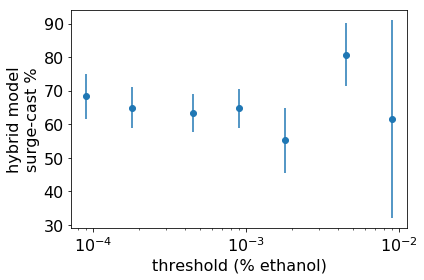

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from plot import set_font_size

# plot infotaxis/surge-cast results vs threshold used
means = []
stds = []

for threshold, dstr in zip(THRESHOLDS, dstrs):
    
    means.append(np.nanmean(dstr))
    stds.append(np.nanstd(dstr))

conversion_factor = 0.0476 / 526

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)

ax.errorbar(conversion_factor * np.array(THRESHOLDS), means, yerr=stds, fmt='o')
ax.set_xscale("log", nonposx='clip')

ax.set_xlabel('threshold (% ethanol)')
ax.set_ylabel('hybrid model\nsurge-cast %')

set_font_size(ax, 16)

fig.savefig('pngs_final/vary_threshold_hybrid.png', dpi=300)